In [68]:
import sys
import random
import os
import numpy as np
import iisignature as iis
import matplotlib.pyplot as plt
import gudhi
from gudhi import plot_persistence_diagram
from gudhi import plot_persistence_density
from gtda.homology import VietorisRipsPersistence
from gtda.homology import FlagserPersistence
from gtda.diagrams import PersistenceEntropy
from gtda.diagrams import Amplitude
from gudhi.representations.vector_methods import Entropy
from gtda.diagrams import PairwiseDistance
from gtda.plotting import plot_diagram
import numpy.random as rd
import gudhi.representations
import random

In [69]:
def logistic(r, x):
    return (1 - r * (x**2))
    # alternative  chaotic map
    # return(4*x*(1-x))


# See book of Kaneko for parameters of eps and/or r to have different regimes
# or https://en.wikipedia.org/wiki/Coupled_map_lattice for notable regimes


# Generate couple map lattice according to this equation: x_i^t= (1-\eps)f[x_i^{t-1}] + \eps/order \sum_{j in \neighbours} f[x_j]^{t-1}
def generate_couple_map(T, N, epsilon, transient_time, r, order=2):
    series = {}

    # Filing the dictionary with N initial random values
    for index_series in range(0, N):
        s = random.random()
        series[index_series] = [s]

    # Generate the coupled maps for a length of size T (yet, we discard the first transient_time elements to remove the transient)
    for i in range(1, T + transient_time + 1):
        for index_series in range(0, N):
            order_k_term = compute_neighbours(N, series, epsilon, index_series, i - 1, r, order)
            new_point = (1 - epsilon) * logistic(r,series[index_series][i - 1]) + order_k_term
            series[index_series].append(new_point)
    return(series)



def compute_neighbours(N, series, epsilon, index_series, i, r, order=2):
    eps_overN = epsilon * (1 / order)
    term_left_right = int(order / 2)

    term = 0
    # Sum over the left neighbors with periodic boundary conditions
    for s in range(1, term_left_right + 1):
        term += logistic(r, series[(index_series - s) % N][i])

    # Sum over the right neighbors with periodic boundary conditions
    for s in range(1, term_left_right + 1):
        term += logistic(r, series[(index_series + s) % N][i])

    # if order is odd, then take the neighbors in an asymmetric way, int(order/2) on the left, int(order/2)+1 on the right
    if order % 2 == 1:
        s = term_left_right + 1
        term += logistic(r, series[(index_series + s) % N][i])

    return(term * eps_overN)

In [70]:
def lead_matrix_1(mv_time_series):
    N=mv_time_series.shape[1]
    sig=iis.sig(mv_time_series,2)
    S=sig[N:].reshape(N,N)
    L=(S-S.T)/2
    return L
def lead_tensor_1(mv_time_series):
    N=mv_time_series.shape[1]
    sig=iis.sig(mv_time_series,3)
    l=N+N*N
    S=sig[l:].reshape(N,N,N)
    T=(S-S.transpose((0,2,1))+S.transpose((2,0,1))-S.transpose((2,1,0))+S.transpose((1,2,0))-S.transpose((1,0,2)))/6
    return T

In [71]:
def rev_directed(L):
    l=L.shape[0]
    a=np.max(np.abs(L))
    for i in range(l):
        for j in range(l):
            if L[j,i]<0:
                L[j,i]=0
                
    ADM=a*np.ones((l,l))-a*np.identity(l)-L            
    dgm=FlagserPersistence().fit_transform([ADM])
    return dgm

def rev_undirected(L):
    l=L.shape[0]
    a=np.max(np.abs(L))
    ADM=a*np.ones((l,l))-a*np.identity(l)-np.abs(L)
    VR= VietorisRipsPersistence(metric="precomputed")
    dgm= VR.fit_transform([ADM])
    return dgm

In [72]:
def create_filtration_2(Lead_matrix, Lead_tensor,indifferent_value):
    

    # Creating the list of simplicial complex with all the edges and triangles
    sc=gudhi.SimplexTree()
    list_simplices = []
    N=Lead_matrix.shape[0]
    for i in range(N):
        for j in range(N):
            if np.abs(Lead_matrix[i,j])<indifferent_value:
                Lead_matrix[i,j]=0
            for k in range(N):
                if np.abs(Lead_tensor[i,j,k])<indifferent_value:
                    Lead_tensor[i,j,k]=0

        

        # Selecting the extremal weight between edges and triplets. It will be assigned to all the nodes (i.e. nodes enter at the same instant)
    m_weight = np.max([np.ceil(np.max(np.abs(Lead_matrix))), np.ceil(np.max(np.abs(Lead_tensor)))])
    # Adding all the nodes from the beginning with the same weights
    for i in range(N):
        list_simplices.append(([i], m_weight))

        # Adding the edges:
        # Also, modify the signs of the weights to correct the z-score so that: if the edge signal is fully coherent, then assign a positive sign, otherwise negative
    for i in range(N):
        for j in range(i,N):
            if (not i==j):
                weight=np.abs(Lead_matrix[i,j])
                list_simplices.append(([i,j], weight))

        # Adding the triplets
        # Here I modify the signs of the weights, if it is fully coherent I assign a positive sign, otherwise negative
    for i in range(N):
        for j in range(i,N):
            for k in range(j,N):
                if ((not (i==j)) and (not(j==k)) and (not(i==k))):
                    weight=np.abs(Lead_tensor[i,j,k])
                    list_simplices.append(([i,j,k], weight))

    sorted_simplices = sorted(list_simplices, key=lambda x: x[1], reverse=True)

        # Remove the violations
    list_violating_triangles = []
    set_simplices = set()
    counter = 0
    triangles_count = 0
    violation_triangles = 0
    violation_triangles_negativeterms = 0

        # Loop over the sorted simplices, and flippling the sign of all the weights (so that the points in the persistence diagram are above the diagonal)
    for index, i in enumerate(sorted_simplices):
        simplices, weight = i

            # If the current simplex is an edge or a node, then I will immediately include it
        if len(simplices) <= 2:
            sc.insert(simplices, -weight)
            set_simplices.add(tuple(simplices))
            counter += 1
        else:
        # If the current simplex is a triplet, I check whether all the sub-simplices have been included.
            flag = 0
            n0=simplices[0]
            n1=simplices[1]        
            n2=simplices[2]
            if (n0,n1) in set_simplices:
                flag=flag+1
            if (n1,n2) in set_simplices:
                flag=flag+1
            if (n0,n2) in set_simplices:
                flag=flag+1

                # If all the sub-simplices already belong to the set, then I add it in the filtration
            if flag == 3:
                set_simplices.add(tuple(simplices))
                sc.insert(simplices, -weight)
                counter += 1
                triangles_count += 1
            else:
                violation_triangles += 1
                list_violating_triangles.append((simplices, np.abs(weight), 3 - flag))

# Fraction of positive triangle discarderd (a.k.a. the hyper coherence)
    hyper_coherence = (1.0 * violation_triangles) /(triangles_count + violation_triangles)
        
    return(sc, list_violating_triangles,hyper_coherence)

In [73]:
def hyper_coherence(mv_time_series,indifferent_value):
    L=lead_matrix_1(mv_time_series)
    T=lead_tensor_1(mv_time_series)
    f=create_filtration_2(L,T,indifferent_value)
    hyp=f[2]
    return hyp

def create_diagram_directly_2(mv_time_series, indifferent_value):
    L=lead_matrix_1(mv_time_series)
    T=lead_tensor_1(mv_time_series)
    f=create_filtration_2(L,T,indifferent_value)
    sc=f[0]    
    dgm=sc.persistence()
    return dgm

In [124]:
data_PS=generate_couple_map(20000,100,0.4, 1, 1.71, order=2)
ts_PS=np.zeros((401,100))
for j in range(100):
    ts_PS[:,j]=data_PS[j][10000::25]
    
    
data_CBMD=generate_couple_map(20000,100,0.1, 1, 1.85, order=2)
ts_CBMD=np.zeros((401,100))
for j in range(100):
    ts_CBMD[:,j]=data_CBMD[j][10000::25]
    
data_FDC=generate_couple_map(20000,100,0.3, 1, 2.00, order=2)
ts_FDC=np.zeros((401,100))
for j in range(100):
    ts_FDC[:,j]=data_FDC[j][10000::25]
    
data_STI=generate_couple_map(20000,100,0.6, 1, 1.75, order=2)
ts_STI=np.zeros((401,100))
for j in range(100):
    ts_STI[:,j]=data_STI[j][10000::25]
    
    
data_DT=generate_couple_map(20000,100,0.1, 1, 1.895, order=2)
ts_DT=np.zeros((401,100))
for j in range(100):
    ts_DT[:,j]=data_DT[j][10000::25]

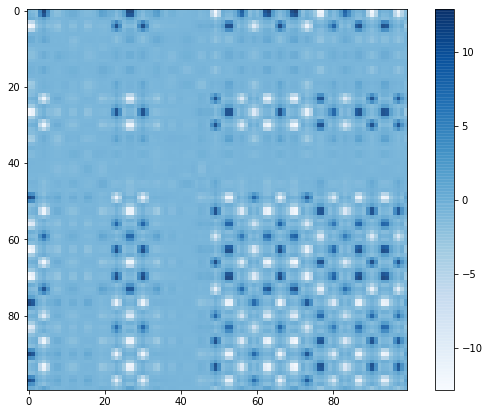

In [125]:
# PS
L_PS=lead_matrix_1(ts_PS)
plt.figure(figsize=(10,7))
plt.imshow(L_PS, alpha=0.9, cmap="Blues")
plt.colorbar()

In [126]:
# clique oriented PS
dgm_clique_or_PS=rev_directed(L_PS)
plot_diagram(dgm_clique_or_PS[0])

0.10528138528138528


<AxesSubplot:title={'center':'Persistence diagram'}, xlabel='Birth', ylabel='Death'>

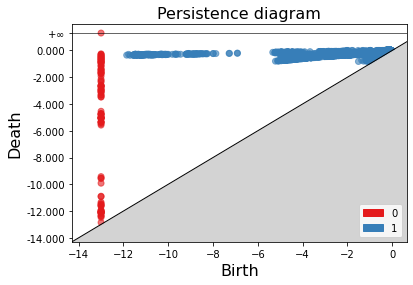

In [127]:
# high order, violating triangles PS
indifference_value=0.05
print(hyper_coherence(ts_PS,indifference_value))
dgm_high_PS=create_diagram_directly_2(ts_PS,indifference_value)
gudhi.plot_persistence_diagram(dgm_high_PS)

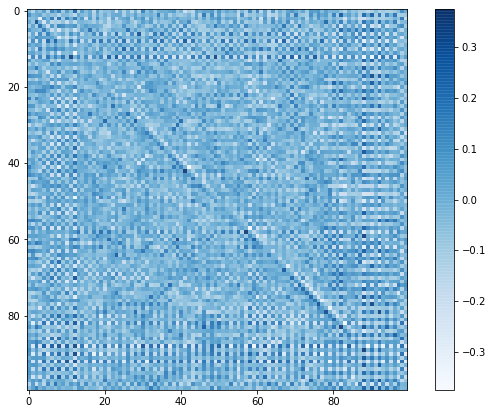

In [128]:
# CBMD CBMD
L_CBMD=lead_matrix_1(ts_CBMD)
plt.figure(figsize=(10,7))
plt.imshow(L_CBMD, alpha=0.9, cmap="Blues")
plt.colorbar()

In [129]:
# clique oriented CBMD
dgm_clique_or_CBMD=rev_directed(L_CBMD)
plot_diagram(dgm_clique_or_CBMD[0])

0.0


<AxesSubplot:title={'center':'Persistence diagram'}, xlabel='Birth', ylabel='Death'>

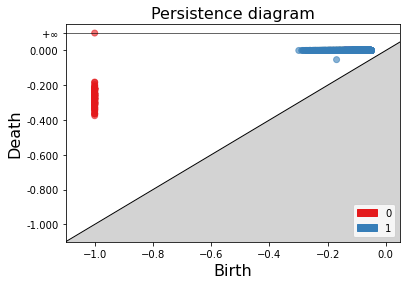

In [130]:
# high order, violating triangles CBMD
indifference_value=0.05
print(hyper_coherence(ts_CBMD,indifference_value))
dgm_high_CBMD=create_diagram_directly_2(ts_CBMD,indifference_value)
gudhi.plot_persistence_diagram(dgm_high_CBMD)

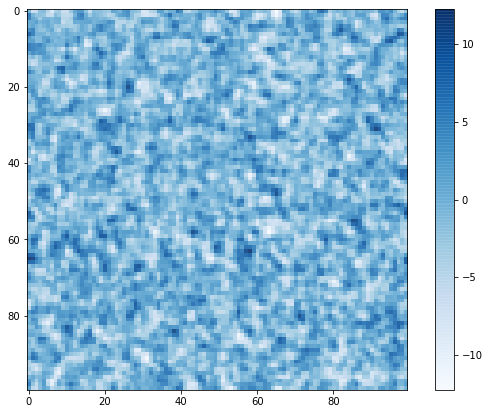

In [131]:
# FDC
L_FDC=lead_matrix_1(ts_FDC)
plt.figure(figsize=(10,7))
plt.imshow(L_FDC, alpha=0.9, cmap="Blues")
plt.colorbar()

In [132]:
# clique oriented FDC
dgm_clique_or_FDC=rev_directed(L_FDC)
plot_diagram(dgm_clique_or_FDC[0])

0.458330241187384


<AxesSubplot:title={'center':'Persistence diagram'}, xlabel='Birth', ylabel='Death'>

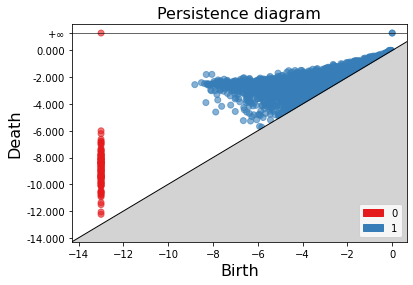

In [133]:
# high order, violating triangles FDC
indifference_value=0.05
print(hyper_coherence(ts_FDC,indifference_value))
dgm_high_FDC=create_diagram_directly_2(ts_FDC,indifference_value)
gudhi.plot_persistence_diagram(dgm_high_FDC)

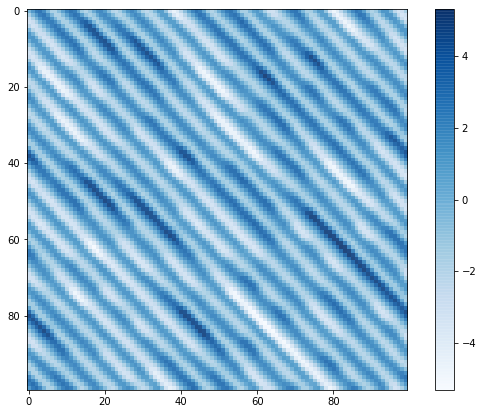

In [134]:
# STI
L_STI=lead_matrix_1(ts_STI)
plt.figure(figsize=(10,7))
plt.imshow(L_STI, alpha=0.9, cmap="Blues")
plt.colorbar()

In [135]:
# clique oriented STI
dgm_clique_or_STI=rev_directed(L_STI)
plot_diagram(dgm_clique_or_STI[0])

0.08343846629560915


<AxesSubplot:title={'center':'Persistence diagram'}, xlabel='Birth', ylabel='Death'>

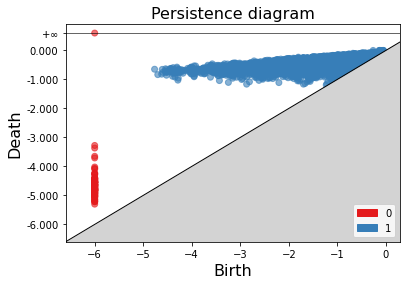

In [136]:
# high order, violating triangles STI
indifference_value=0.05
print(hyper_coherence(ts_STI,indifference_value))
dgm_high_STI=create_diagram_directly_2(ts_STI,indifference_value)
gudhi.plot_persistence_diagram(dgm_high_STI)

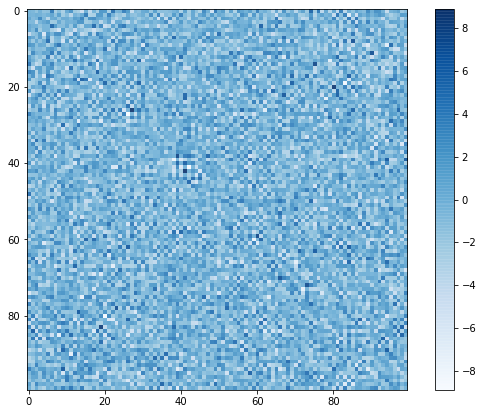

In [137]:
# DT
L_DT=lead_matrix_1(ts_DT)
plt.figure(figsize=(10,7))
plt.imshow(L_DT, alpha=0.9, cmap="Blues")
plt.colorbar()

In [138]:
# clique oriented DT
dgm_clique_or_DT=rev_directed(L_DT)
plot_diagram(dgm_clique_or_DT[0])

0.443747680890538


<AxesSubplot:title={'center':'Persistence diagram'}, xlabel='Birth', ylabel='Death'>

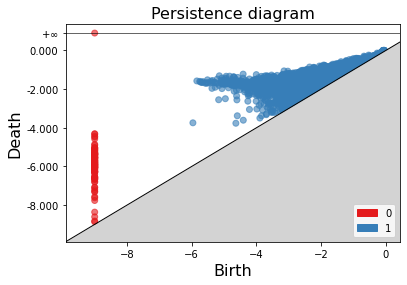

In [139]:
# high order, violating triangles DT
indifference_value=0.05
print(hyper_coherence(ts_DT,indifference_value))
dgm_high_DT=create_diagram_directly_2(ts_DT,indifference_value)
gudhi.plot_persistence_diagram(dgm_high_DT)

In [140]:
# HYPER COHERENCE CURVES

# Hyper PS
hyp_PS=[]
indifference_value=0.05
for i in range(1,40):
    sub_ts_PS=ts_PS[:10*i,:]
    hyp=hyper_coherence(sub_ts_PS,indifference_value)
    hyp_PS.append(hyp)

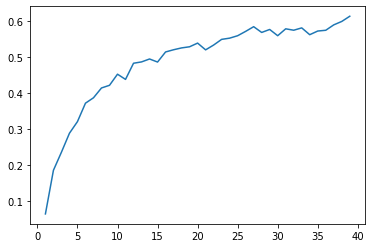

In [141]:
plt.plot(range(1,40),hyp_PS)
plt.show()

In [142]:
# HYPER COHERENCE CURVES

# Hyper DT
hyp_DT=[]
indifference_value=0.05
for i in range(1,40):
    sub_ts_DT=ts_DT[:10*i,:]
    hyp=hyper_coherence(sub_ts_DT,indifference_value)
    hyp_DT.append(hyp)

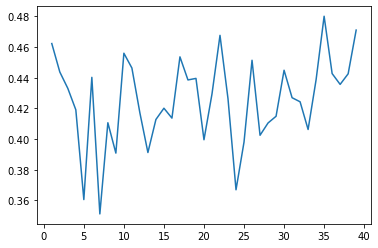

In [143]:
plt.plot(range(1,40),hyp_DT)
plt.show()

In [144]:
# HYPER COHERENCE CURVES

# Hyper STI
hyp_STI=[]
indifference_value=0.05
for i in range(1,40):
    sub_ts_STI=ts_STI[:10*i,:]
    hyp=hyper_coherence(sub_ts_STI,indifference_value)
    hyp_STI.append(hyp)

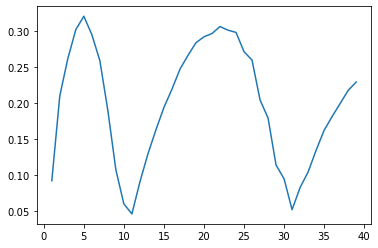

In [145]:
plt.plot(range(1,40),hyp_STI)
plt.show()

In [146]:
# HYPER COHERENCE CURVES

# Hyper FDC
hyp_FDC=[]
indifference_value=0.05
for i in range(1,40):
    sub_ts_FDC=ts_FDC[:10*i,:]
    hyp=hyper_coherence(sub_ts_FDC,indifference_value)
    hyp_FDC.append(hyp)

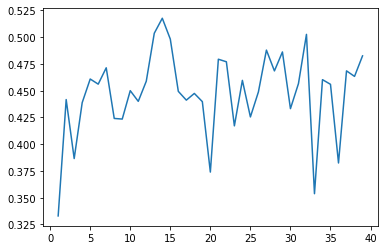

In [147]:
plt.plot(range(1,40),hyp_FDC)
plt.show()

In [148]:
# HYPER COHERENCE CURVES

# Hyper CBMD
hyp_CBMD=[]
indifference_value=0.05
for i in range(1,40):
    sub_ts_CBMD=ts_CBMD[:10*i,:]
    hyp=hyper_coherence(sub_ts_CBMD,indifference_value)
    hyp_CBMD.append(hyp)

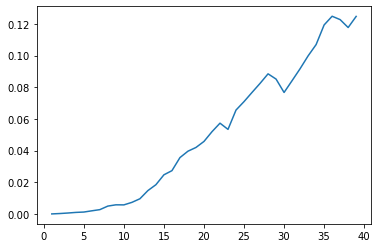

In [149]:
plt.plot(range(1,40),hyp_CBMD)
plt.show()